In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109a_hw1.ipynb")

<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science </h1>

## Homework 1: Web Scraping, Data Parsing, and EDA

**Harvard University**<br/>
**Fall 2022**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pilai



<hr style='height:2px'>

In [25]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Exercise **responsible scraping**. Web servers can become slow or unresponsive if they receive too many requests from the same source in a short amount of time. Use a delay of 2 seconds between requests in your code.  
- Web scraping requests can take several minutes. This is another reason why you should not wait until the last minute to do this homework.
- Plots should be legible and interpretable without having to refer to the code that generated them.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- The use of 'hard-coded' values to try and pass tests rather than solving problems programmatically will not receive credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells. This is how the notebook will be evaluated (this can take a few minutes)

In [26]:
import json
from time import sleep
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

<hr style='height:2px'>

## ⭐ Follow the stars in IMDb's list of "The Top 100 Stars for 2021" 

### Overview
In this assignment you'll practice scraping, parsing, and analyzing HTML data pulled from web.

Specifically, you'll extract information about each person on IMDb's list of "Top 100 Stars for 2021" (https://www.imdb.com/list/ls577894422/), perform some EDA, ask some questions of the data, and interpret your findings.

For example, we might like to know: 
- What is the relationship between when a performer started their career and their total number of acting credits? 
- How many stars started as child actors?
- How do the distribution of ages compare across genders?
- Who is the most prolific actress or actor in IMDb's list of the Top 100 Stars for 2021? 

These questions and more are addressed in details below. 

## Part 1 - Scraping and Parsing

<div class='exercise'><b>Q1 - Scrape Top Stars List</b></div>

Scrape the HTML from the webpage of the "Top 100 Stars for 2021" (https://www.imdb.com/list/ls577894422/) into a `requests` object and name it `my_page`. 

_Points:_ 2.5

In [27]:
my_page = requests.get('https://www.imdb.com/list/ls577894422/')
my_page.status_code

200

In [28]:
grader.check("q1")

q1 results: All test cases passed!

<div class='exercise'><b>Q2 - Making BeautifulSoup</b></div>

Create a Beautiful Soup object named `star_soup` from the HTML content in `my_page`.


_Points:_ 2.5

In [29]:
raw_html = my_page.text
print(raw_html[:5000])




<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
         

        <meta charset="utf-8">




        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>

<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
</script>
  <script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
        <title>Top 100 Stars of 2021 - IMDb</title>
  <script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
<script>
    if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
</script>
<script>
    if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
</script>

        <link rel="canonical" href="https://www.imdb.com/list/ls577894422/" />
        <meta property="og:url" content="http://ww

In [30]:
star_soup = BeautifulSoup(raw_html, 'html.parser')

In [31]:
# check your code - you should see a familiar HTML code
print (star_soup.prettify()[:1000])

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   var IMDbTimer={starttime: new Date().getTime(),pt:'java'};
  </script>
  <script>
   if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
  </script>
  <script>
   (function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);
  </script>
  <title>
   Top 100 Stars of 2021 - IMDb
  </title>
  <script>
   (function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);
  </script>
  <script>
   if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
  </script>
  <script>
   if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
  </script>
  <link href="https://www.imdb.com/list/ls577894422/" rel="canonical"/>
  <meta content="http://www.imdb.com/list/ls577894422/" property="og

In [32]:
grader.check("q2")

q2 results: All test cases passed!

<div class='exercise'><b>Q3 - Parse Stars</b></div>

Write a function called `parse_stars` that accepts `star_soup` as its input and returns a list of dictionaries to be saved in a variable called `star_list` (see function definition below for details)

IMDb star pages do not have a 'sex' or 'gender' field. Some roles are gender neutral (e.g., "writer") and relying on actor/actress distinctions will also give results inconsistent with the more detailed data available on the site. You should infer gender based on the frequency of the personal pronouns used in each star's truncated bio that appears on the main "Top 100 Star of 2021" page.

You may find a data structure like this useful:

```python
pronouns = {'woman': ['she','her'],
            'man': ['he', 'him', 'his'],
            'non-binary': ['they', 'them', 'their']}
```

Simply count the occurrences of the different pronouns in the bio and make the classification based on the grouping with the majority count.

>**Hint:** Throughout this assignment you will likely find it useful to create small 'helper' functions which are then used by your larger functions like `parse_stars`

```
Function
--------
parse_stars

Input
------
star_soup: the soup object with the scraped page
   
Returns
-------
a list of dictionaries; each dictionary corresponds to a star profile and has the following data:

    name: (str) the name of the star
    role: (str) role in film designated on top 100 page (e.g., 'actress', 'writer')
    gender: (str) 'man', 'woman', or 'non-binary' based in pronoun counts in top 100 page bio
    url: (str) the url of the link under star's name that leads to a page with more details
    page: (bs4.BeautifulSoup) BS object acquired by scraping and parsing the above 'url' page

Example:
--------
{'name': 'Elizabeth Olsen',
 'role': 'actress',
 'gender': 'woman',
 'url': 'https://www.imdb.com/name/nm0647634',
 'page': <!DOCTYPE html>
 <html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
 <meta charset="utf-8"/>
 <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
 <script>
 ...
}

```

_Points:_ 25

In [33]:
pronouns = {'woman': ['she','her'],
            'man': ['he', 'him', 'his'],
            'non-binary': ['they', 'them', 'their']}

In [34]:
star_nodes = star_soup.select('.lister-item-content')

def get_star_name(star_node):
    return star_node.select_one('h3 a').text.strip().replace('\n','')

def get_star_role(star_node):
    star_role = star_node.select_one('p').text.strip()
    star_role = star_role[:star_role.index('|')]
    return star_role

def get_star_gender(star_node):
    star_descriptions = star_node.select('p')[1].text.strip().lower()
    # return star_descriptions
    if star_descriptions.find('she') != -1:
        return 'woman'
    elif star_descriptions.find('he') != -1:
        return 'man'
    elif star_descriptions.find('they') != -1:
        return 'non-binary'

In [35]:
def get_star_url(star_node):
    url = 'https://www.imdb.com' + star_node.select_one('h3 a').get("href")
    return url

In [36]:
def get_star_page(star_node):
    url = 'https://www.imdb.com' + star_node.select_one('h3 a').get("href")
    html = requests.get(url).text.strip()   
    html_soup = BeautifulSoup(html)
    return html_soup

In [116]:
# list_star_name = []
# for star_node in star_nodes:
#     list_star_name.append(get_star_name(star_node))
    
# list_star_name[:5]

In [117]:
# list_star_role = []
# for star_node in star_nodes:
#     star_role =  get_star_role(star_node)
#     star_role =  star_role[:star_role.index('|')]
#     list_star_role.append(star_role)
    
# list_star_role[:5]

In [118]:
# list_star_gender = []
# for star_node in star_nodes:
#     star_gender =  get_star_gender(star_node)
#     list_star_gender.append(get_star_gender(star_node))
    
# list_star_gender[:5]

In [119]:
# list_star_url = []
# list_star_html = []

# for star_node in star_nodes:
#     url = url + get_star_url(star_node)
#     html = url + get_star_url(star_node)
#     list_star_url.append(url)
#     list_star_html.append(html)
    
# list_star_url[:5]
# list_star_html[:2]

In [37]:
# check your code
# this list is large because of the html code into the `page` field
# to get a better picture, print only the first element

star_list = []
for star_node in star_nodes:
    # Initialize the dictionary
    star = {} #{key: value}
    
    star['name'] = get_star_name(star_node)
    star['role'] = get_star_role(star_node)
    star['gender'] = get_star_gender(star_node)
    star['url'] = get_star_url(star_node)
    star['page'] = get_star_page(star_node) 
    star_list.append(star)
    
star_list[0]


{'name': 'Elizabeth Olsen',
 'role': 'Actress ',
 'gender': 'woman',
 'url': 'https://www.imdb.com/name/nm0647634',
 'page': <!DOCTYPE html>
 <html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
 <meta charset="utf-8"/>
 <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
 <script>
     if (typeof uet == 'function') {
       uet("bb", "LoadTitle", {wb: 1});
     }
 </script>
 <script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
 <title>Elizabeth Olsen - IMDb</title>
 <script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
 <script>
     if (typeof uet == 'function') {
       uet("be", "LoadTitle", {wb: 1});
     }
 </script>
 <script>
     if (typeof uex == 'function') {
       uex("ld", "LoadTitle", {wb: 1});
     }
 </script>
 <link href="https://www.imdb.com/name/nm064763

In [38]:
grader.check("q3")

q3 results: All test cases passed!

<div class='exercise'><b>Q4 - Create Star Table</b></div>

Write a function called `create_star_table`, which takes `star_list` as an input and returns a *new* list of dictionaries, `star_table`, which includes more extensive information about each star extracted from their `page`. 

See function the definition below for more details.

>**Note:** The years of some credits are ranges (e.g., 2001-2002). You should use only the starting year.

>**Hint:** Carefuly note the ordering, case, and data type of the values in each dictionary.

```
Function
--------
create_star_table

Input
------
star_list (list of dictionaries)
   
Returns
-------

a list of dictionaries; each dictionary corresponds to a star profile and has the following data:

    name: (str) the name of the star
    role: (str) 'actor', 'actress', 'writer', etc. (note the case)
    gender: (str) 'woman', 'man', or 'non-binary' (based on pronouns in bio)  
    year_born : (int) year star was born (some pages do note have a full date so we'll just use year)
    first_credit: (str) title of their first credit in their capacity designated by 'role'
    year_first_credit: (int) the year they made their first movie or TV show
    num_credits: (int) number of movies or TV shows they have made over their career in their capacity designated by 'role'
    
--------
Example:

{'name': 'Elizabeth Olsen',
  'role': 'actress',
  'gender': 'woman',
  'year_born': 1989,
  'first_credit': 'How the West Was Fun',
  'year_first_credit': 1994,
  'num_credits': 27}
  
```

_Points:_ 25

In [39]:
list_star_gender = []
for star_node in star_nodes:
    list_star_gender.append(get_star_gender(star_node))

In [40]:
list_star_html = []
for star_node in star_nodes:
    list_star_html.append(get_star_page(star_node))

In [41]:
list_star_html[0]

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<meta charset="utf-8"/>
<script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
</script>
<script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
<title>Elizabeth Olsen - IMDb</title>
<script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
<script>
    if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
</script>
<script>
    if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
</script>
<link href="https://www.imdb.com/name/nm0647634/" rel="canonical"/>
<meta content="http://www.imdb.com/name/nm0647634/" property="og:url"/>
<link href="https://m.imdb.com/name/nm0647634/" media=

In [42]:
def list_star_bios(each_star_soup):
    bio_nodes = each_star_soup.select_one('.name-overview-widget')
    star_name = bio_nodes.select('h1 .itemprop')[0].text
    star_role = bio_nodes.select('.infobar a')[0].text.strip()
    star_year_nodes = bio_nodes.select_one('time')
    star_year = star_year_nodes['datetime'][:4]
    credit_nodes = each_star_soup.select_one('.head').text.strip()
    credits = credit_nodes[credit_nodes.index('(')+1:credit_nodes.index(')')]
    num_credits = credits[:credits.index(' ')]
    film_nodes = each_star_soup.select('.filmo-category-section')[0]
    first_credit = film_nodes.select('div b a')[-1].text.strip()
    year_first_credit = film_nodes.select('.year_column')[-1].text.strip()
    return star_name, star_role, star_year, num_credits, first_credit,year_first_credit

In [43]:
star_table = []
# for star_node in star_nodes:
#     star = {}
#     star['name'] = get_star_name(star_node)
#     star['role']= get_star_role(star_node)
#     star['gender'] = get_star_gender(star_node)
#     star['url']= get_star_url(star_node)
#     # star['page'] = get_star_page(star_node)
#     star_list.append(star)
    
def create_star_table(star_list: list) -> list:
    for html in list_star_html:
        star = {}
        # my_url=requests.get(url)
        # raw_html = my_url.text
        # each_star_soup = BeautifulSoup(raw_html, 'html.parser')
        star_name, star_role, star_year, num_credits, first_credit,year_first_credit = list_star_bios(html)
        star['name'] = star_name
        star['role']= star_role
        star['gender'] = list_star_gender[list_star_html.index(html)]
        star['year_born']= star_year
        star['first_credit']= first_credit
        star['year_first_credit']= year_first_credit
        star_table.append(star)
create_star_table (list_star_html) 
star_table[0]

{'name': 'Elizabeth Olsen',
 'role': 'Actress',
 'gender': 'woman',
 'year_born': '1989',
 'first_credit': 'How the West Was Fun',
 'year_first_credit': '1994'}

In [173]:
# check your code
star_table

[{'name': 'Elizabeth Olsen',
  'role': 'Actress',
  'gender': 'woman',
  'year_born': '1989',
  'first_credit': 'How the West Was Fun',
  'year_first_credit': '1994'},
 {'name': 'Regé-Jean Page',
  'role': 'Actor',
  'gender': 'man',
  'year_born': '1988',
  'first_credit': 'Gimme 6',
  'year_first_credit': '2001'},
 {'name': 'Florence Pugh',
  'role': 'Actress',
  'gender': 'woman',
  'year_born': '1996',
  'first_credit': 'The Falling',
  'year_first_credit': '2014'},
 {'name': 'Ana de Armas',
  'role': 'Actress',
  'gender': 'woman',
  'year_born': '1988',
  'first_credit': 'Una rosa de Francia',
  'year_first_credit': '2006'},
 {'name': 'Yvonne Strahovski',
  'role': 'Actress',
  'gender': 'woman',
  'year_born': '1982',
  'first_credit': 'Double the Fist',
  'year_first_credit': '2004'},
 {'name': 'Anya Taylor-Joy',
  'role': 'Actress',
  'gender': 'woman',
  'year_born': '1996',
  'first_credit': 'Vampire Academy',
  'year_first_credit': '2014'},
 {'name': 'Alexandra Daddario',
 

In [174]:
grader.check("q4")

q4 results: All test cases passed!

### 💡 Saving and Restoring Our List of Dictionaries

It's good practice to save your data structure to disk once you've done all of your scraping. This way you can often avoid repeating all the HTTP requests which can be slow (and taxing on servers!).

We had to wait until this stage to save our data structure as the `bs4.BeautifulSoup` object in our original `star_list` (the `page` values) can not be easily [serialized](https://docs.python-guide.org/scenarios/serialization/).

The code provided below will save the data structure to a [JSON](https://www.json.org/json-en.html) file named `starinfo.json` in the data subdirectory.

In [33]:
# your code here
with open("data/starinfo.json", "w") as f:
    json.dump(star_table, f)

NameError: name 'star_table' is not defined

To confirm this worked as intended, open the JSON file and load its contents into a variable for viewing.

In [34]:
with open("data/starinfo.json", "r") as f:
    star_table = json.load(f)
    
# output should be the same
star_table

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

This method of saving and restoring data structures will likely be useful to you in the future!

## Part 2 - Pandas and EDA

<div class='exercise'><b>Q5 - Creating a DataFrame</b></div>

For the sake of consistency, we've provide our own JSON file, `data/starinfo_2021_staff.json`, which you should use for the rest of the notebook. Load the contents of this JSON file and use it to create a Pandas DataFrame called `frame`. 

>**Hint:** Remember, the data structure in the JSON file is a list of dictionaries.

_Points:_ 2.5

In [54]:
frame = pd.read_json("data/starinfo_2021_staff.json")

In [55]:
# Take a peek
frame.head(20)

,name,role,gender,year_born,first_credit,year_first_credit,num_credits
0,Elizabeth Olsen,actress,woman,1989,How the West Was Fun,1994,27
1,Regé-Jean Page,actor,man,1988,Gimme 6,2001,20
2,Florence Pugh,actress,woman,1996,The Falling,2014,28
3,Ana de Armas,actress,woman,1988,Una rosa de Francia,2006,32
4,Yvonne Strahovski,actress,woman,1982,Double the Fist,2004,39
5,Anya Taylor-Joy,actress,woman,1996,Vampire Academy,2014,32
6,Alexandra Daddario,actress,woman,1986,All My Children,2002,62
7,Jodie Comer,actress,woman,1993,The Royal Today,2008,34
8,Ben Barnes,actor,man,1981,The Kooks: The Sofa Song,2005,37
9,Lily James,actress,woman,1989,Just William,2010,35


In [56]:
grader.check("q5")

q5 results: All test cases passed!

<div class='exercise'><b>Q6 - Creating a New Column</b></div>

Add a new column to your dataframe with the *approximate* age of each star at the time of their first credit. Name this new column `age_at_first_credit`.

>**NOTE:** We say *approximate* age because we've only collected the year of birth as several star pages do not include a full birth date. **The approximate age of a star in a given year should be the difference between that year and the star's birth year.**

_Points:_ 2.5

In [57]:
frame['age_at_first_credit'] = frame.year_first_credit - frame.year_born

In [58]:
# You should visually inspect some of your results
frame.head()

,name,role,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
0,Elizabeth Olsen,actress,woman,1989,How the West Was Fun,1994,27,5
1,Regé-Jean Page,actor,man,1988,Gimme 6,2001,20,13
2,Florence Pugh,actress,woman,1996,The Falling,2014,28,18
3,Ana de Armas,actress,woman,1988,Una rosa de Francia,2006,32,18
4,Yvonne Strahovski,actress,woman,1982,Double the Fist,2004,39,22


<div class='exercise'><b>Q7 - Subsetting and Sorting</b></div>

In this section you'll subset and sort the DataFrame to answer a pair of questions:

<div class='exercise'><b>Q7.1 - Child Stars</b></div>

Which stars received their first credit **before the age of 11?**

Store the resulting dataframe as `child_stars`sorted by `age_at_first_credit` in **ascending** order.\
Store the number of such "child stars" in `num_child_stars`.

_Points:_ 2.5

In [59]:
child_stars = frame[frame.age_at_first_credit <11].sort_values('age_at_first_credit', ascending=True)
num_child_stars = len(child_stars)
# child_stars
print ("{} stars received their first credit before the age of 11.".format(num_child_stars))
display(child_stars)

14 stars received their first credit before the age of 11.


,name,role,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
33,Kate Beckinsale,actress,woman,1973,Couples,1975,54,2
86,Peyton List,actress,woman,1998,As the World Turns,2002,62,4
0,Elizabeth Olsen,actress,woman,1989,How the West Was Fun,1994,27,5
75,Leonardo DiCaprio,actor,woman,1974,Romper Room,1979,46,5
95,Soleil Moon Frye,actress,woman,1976,Missing Children: A Mother's Story,1982,60,6
31,Mckenna Grace,actress,woman,2006,The Goodwin Games,2013,66,7
80,Jacob Tremblay,actor,man,2006,Motive,2013,40,7
17,Alexander Skarsgård,actor,man,1976,Ake and His World,1984,70,8
40,Angourie Rice,actress,woman,2001,Hidden Clouds,2009,26,8
50,Shailene Woodley,actress,woman,1991,Replacing Dad,1999,41,8


In [60]:
grader.check("q7.1")

q7.1 results: All test cases passed!

<div class='exercise'><b>Q7.2 - Late Bloomers</b></div>

Which stars received their first credit at **26-years-old or older?**

Store the resulting dataframe as `late_bloomers`sorted by `age_at_first_credit` in **descending** order.\
Store the number of such "late bloomers" in `num_late_bloomers`.

_Points:_ 2.5

In [61]:
late_bloomers = frame[frame.age_at_first_credit > 25].sort_values('age_at_first_credit', ascending=False)
num_late_bloomers = len(late_bloomers)

print ("{} stars received their first credit at 26 or older.".format(num_late_bloomers))
display(late_bloomers)

4 stars received their first credit at 26 or older.


,name,role,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit
22,Hannah Waddingham,actress,woman,1974,Coupling,2002,37,28
89,Jean Smart,actress,woman,1951,Before and After,1979,124,28
96,Taika Waititi,writer,man,1975,John & Pogo,2002,28,27
83,Julianne Nicholson,actress,woman,1971,Nothing Sacred,1997,64,26


In [52]:
grader.check("q7.2")

q7.2 results: All test cases passed!

<div class='exercise'><b>Q8 - Visualization  </b></div>

In this section you'll use your Python visualization skills to further explore the data:

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q8.1  - Exploring Trends</b></div>

Create 2 [scatter plots](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html?highlight=scatter#matplotlib.axes.Axes.scatter): one showing the relationship between **age at first movie** and number of credits, the other between **year born** and number of credits.

What can you say about these relationships? Are there any apparent outliers? Please limit your written responses to 4 sentences or fewer.

_Points:_ 5

_Type your answer here, replacing this text._

<AxesSubplot:xlabel='year_born', ylabel='num_credits'>

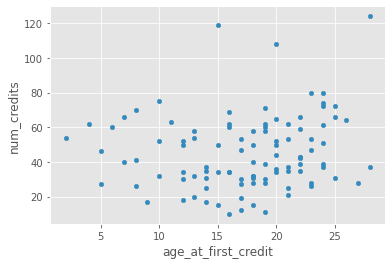

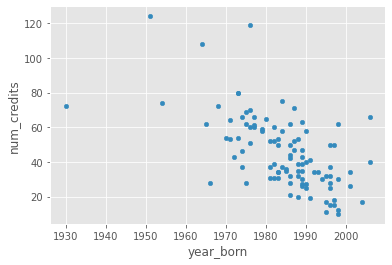

In [62]:
# your code here
frame.plot.scatter(x='age_at_first_credit', y='num_credits')
frame.plot.scatter(x='year_born', y='num_credits')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q8.2 - Age Distributions</b></div>

Let's look at the distribution of movie and TV performers' ages by gender.

Create two plots, each plot consisting of **two overlayed [histograms](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html?highlight=hist#matplotlib.pyplot.hist)** comparing the distribution of men's current ages to women's current ages.

In the first plot, the distributions shcounts of each gender at each ageould be normalized to show the *proportion* of each gender at each age.

The second plot should show the *counts* of each gender at each age. 

Interpret the resulting plots. (4 sentences or fewer)

>**NOTE 1:** Again, we are dealing with *approximate* ages as defined above.

>**NOTE 2:** You should exclude those whose `role` is not 'actor' or 'actress' from your analysis

_Points:_ 10

_Type your answer here, replacing this text._

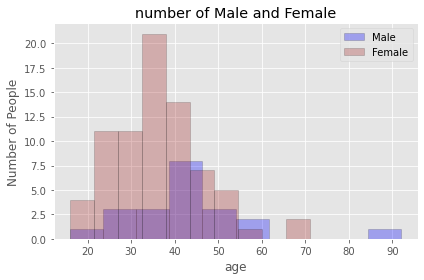

In [68]:
from sklearn import preprocessing


frame['age']=2022 - frame.year_born
frame_actor=frame[frame.role.str.contains('act')]
frame_actor['gender'].value_counts()
female = frame_actor['gender']=='woman'
male = frame_actor['gender']=='man'

#normalized = preprocessing.normalize(frame_actor['age'][male])
    


plt.style.use('ggplot')
plt.title('number of Male and Female')
plt.hist(frame_actor['age'][male], alpha= 0.3,edgecolor='black', color='blue',label='Male')
plt.hist(frame_actor['age'][female], alpha= 0.3,edgecolor='black',color='brown',label='Female')
 
plt.legend(loc='upper right')
plt.xlabel('age')
plt.ylabel('Number of People')
 
plt.tight_layout()
plt.show()





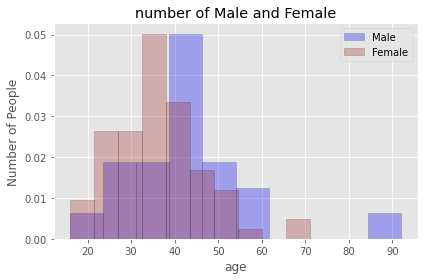

In [69]:
plt.style.use('ggplot')
plt.title('number of Male and Female')

plt.hist(frame_actor['age'][male], alpha= 0.3, density=True,edgecolor='black', color='blue',label='Male')
plt.hist(frame_actor['age'][female], alpha= 0.3, density=True,edgecolor='black',color='brown',label='Female')
 
plt.legend(loc='upper right')
plt.xlabel('age')
plt.ylabel('Number of People')
 
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q8.3 - Credits Per Year</b></div>

credits-per-year-activeCreate a [box plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot) or [violin plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.violin.html?highlight=violin#matplotlib.axes.Axes.violin) comparing the **credits-per-year-active** for men and women performers.

Here we assume all stars in the list are still active. 

Do these distributions look the same across genders? Can you identify the stars corresponding to any outliers? Comment on these points and anything else of interest gleaned from your plot. (6 sentences or fewer)

>**NOTE:** Again, you should exclude those whose `role` is not 'actor' or 'actress' from your analysis.

_Points:_ 10

_Type your answer here, replacing this text._

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


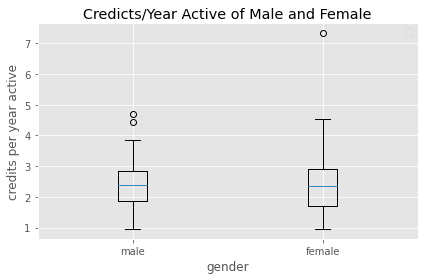

In [70]:
# your code here
frame['year_active'] = 2022-frame.year_first_credit
frame['credits_per_year_active'] = frame.num_credits/frame.year_active

frame_actor=frame[frame.role.str.contains('act')]
frame_actor['gender'].value_counts()
female = frame_actor['gender']=='woman'
male = frame_actor['gender']=='man'

data = [frame_actor['credits_per_year_active'][male], frame_actor['credits_per_year_active'][female]]

plt.style.use('ggplot')
plt.title('Credicts/Year Active of Male and Female')

plt.boxplot(data, labels=['male','female'])

plt.legend(loc='upper right')
plt.xlabel('gender')
plt.ylabel('credits per year active')
 
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q9 - Most Prolific Stars</b></div>

Make a plot visualizing the number of credits received by each star. Who is the most prolific person in IMDb's list of the Top 100 Stars for 2021? Define **most prolific** as the person with the most credits.

>**Note 1:** Your analysis should include all 100 stars

>**Note 2:** The stars in the plots should be sorted based on number of credits to make the plot easier to read.

_Points:_ 10

In [71]:
frame.sort_values(by = ['num_credits'],ascending = False)

,name,role,gender,year_born,first_credit,year_first_credit,num_credits,age_at_first_credit,age,year_active,credits_per_year_active
89,Jean Smart,actress,woman,1951,Before and After,1979,124,28,71,43,2.883721
72,Ryan Reynolds,actor,man,1976,Fifteen,1991,119,15,46,31,3.838710
97,Keanu Reeves,actor,man,1964,Hangin' In,1984,108,20,58,38,2.842105
87,Leslie Bibb,actress,woman,1973,Pacific Blue,1996,80,23,49,26,3.076923
53,Kathryn Hahn,actress,woman,1973,Flushed,1997,80,24,49,25,3.200000
...,...,...,...,...,...,...,...,...,...,...,...
28,Daniela Melchior,actress,woman,1996,Mulheres,2014,15,18,26,8,1.875000
37,Elena Kampouris,actress,woman,1997,Gossip Girl,2012,15,15,25,10,1.500000
91,Erin Kellyman,actress,woman,1998,Raised by Wolves,2015,12,17,24,7,1.714286
93,Victoria Pedretti,actress,woman,1995,Sole,2014,11,19,27,8,1.375000


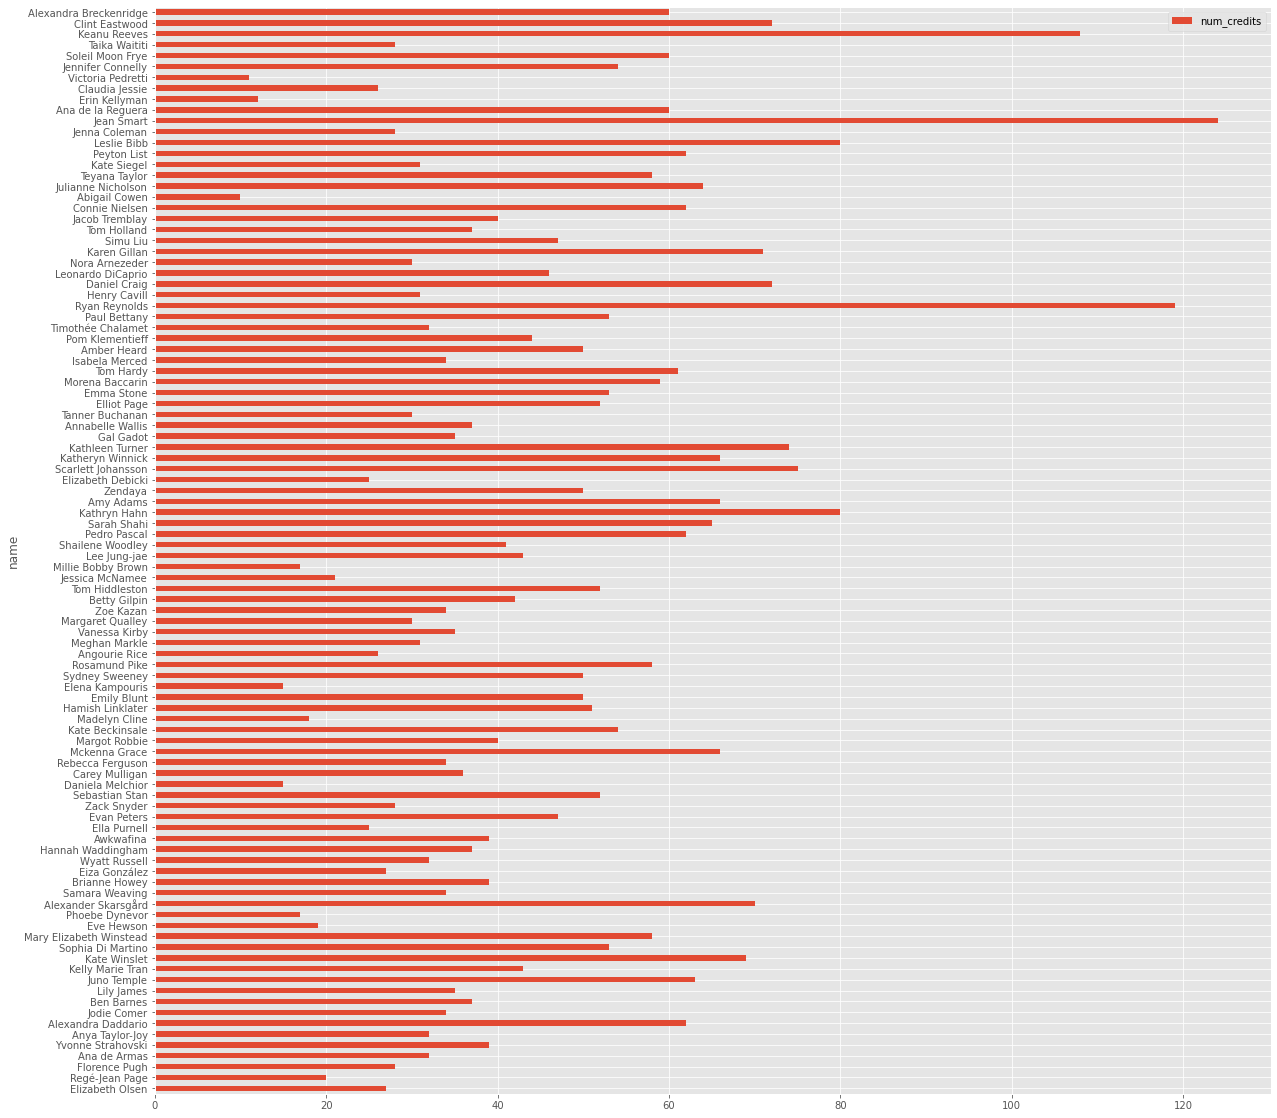

In [97]:
frame.plot.barh(x='name', y='num_credits', rot=0,figsize=(20, 20));

In [72]:
highest_performer_name = 'Jean Smart'
highest_performer_credits = '124'
print ("{} had the most credits with {}".format(highest_performer_name, highest_performer_credits))

Jean Smart had the most credits with 124


<!-- END QUESTION -->

**This concludes HW1. Thank you!**

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()